# American Sign Language Detection 

## Importing the necessary libraries

In [1]:
import cv2
import numpy as np
import math
import time

from skimage import transform
from skimage import io
import matplotlib.pyplot as plt
import os
import numpy as np
from skimage.color import rgb2gray
import random

import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout, Conv2D, MaxPooling2D
from keras.models import Model, Sequential

In [2]:
from cvzone.HandTrackingModule import HandDetector

In [3]:
cap = cv2.VideoCapture(0)
#0 is the ID number for web cam here

In [4]:
detector = HandDetector(maxHands = 1)

## Data Collection:
We use the mediapipe and cvzone libraries to collect our image hand sign data using our web camera.

In [5]:
offset = 20
imgSize = 300

folder = "Data/J"
counter = 0

while True:
    success, img = cap.read()
    hands, img = detector.findHands(img)
    if hands:
        hand = hands[0]
        x, y, w, h = hand['bbox']
        imgWhite = np.ones((imgSize, imgSize, 3), np.uint8)*255
        imgCrop = img[y-offset:y + h+offset, x-offset:x + w+offset]
        imgCropShape = imgCrop.shape
        
        
        aspectRatio = h/w
        if aspectRatio > 1:
            k = imgSize/h
            wCal = math.ceil(k*w)
            imgResize = cv2.resize(imgCrop, (wCal, imgSize))
            imgResizeShape = imgResize.shape
            wGap = math.ceil((imgSize - wCal)/2)
            imgWhite[:, wGap:wCal + wGap] = imgResize
            
        else:
            k = imgSize/w
            hCal = math.ceil(k*h)
            imgResize = cv2.resize(imgCrop, (hCal, imgSize))
            imgResizeShape = imgResize.shape
            hGap = math.ceil((imgSize - hCal)/2)
            imgWhite[:, hGap:hCal + hGap] = imgResize
            
        cv2.imshow("ImageCrop", imgCrop)
        cv2.imshow("ImageWhite", imgWhite)
    cv2.imshow('Image', img)
    key = cv2.waitKey(1)
    if key == ord("s"):
        counter += 1
        cv2.imwrite(f'{folder}/Image_{time.time()}.jpg', imgWhite)
        print(counter)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


## Loading the Data for training:
Function to load the data from a folder and marking them with the corresponding labels

In [6]:
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) for f in os.listdir(label_directory)]
        for f in file_names:
            images.append(io.imread(f))
            labels.append(ord(d))
    return images, labels

ROOT_PATH = "C:/Users/debop/OneDrive/Desktop"
train_data_directory=os.path.join(ROOT_PATH, "Train")

images, labels=load_data(train_data_directory)

## Evaluation set for testing:
Due to a smaller dataset we have used resampling technique to create a test dataset from our training dataset itself.

In [7]:
images_array = np.array(images)
labels_array = np.array(labels)


# Count the number of labels
print("Total No of classes:",len(set(labels_array)))
print("Label Array: ",[chr(X) for X in set(labels)])

Total No of classes: 26
Label Array:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


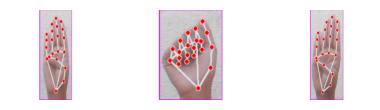

shape: (300, 300, 3), min: 0, max: 255


In [8]:
# Determine the (random) indexes of the images that you want to see 
hand_signs = [256, 34, 434]

# Fill out the subplots with the random images that you defined 
for i in range(len(hand_signs)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(images[hand_signs[i]])
    plt.subplots_adjust(wspace=0.5)

plt.show()

print("shape: {0}, min: {1}, max: {2}".format(images[hand_signs[i]].shape, 
                                                  images[hand_signs[i]].min(), 
                                                  images[hand_signs[i]].max()))

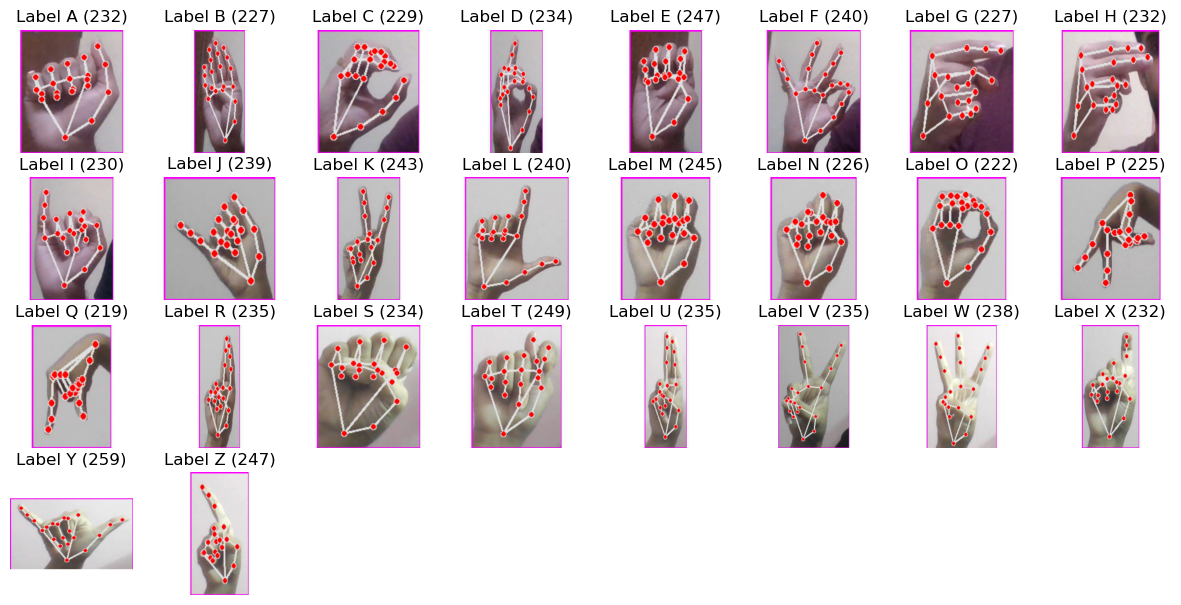

In [9]:
# Get the unique labels 
unique_labels = set(labels)

# Initialize the figure
plt.figure(figsize=(15, 15))

# Set a counter
i = 1

# For each unique label,
for label in unique_labels:
    # You pick the first image for each label
    image = images[labels.index(label)]
    # Define 64 subplots 
    plt.subplot(8, 8, i)
    # Don't include axes
    plt.axis('off')
    # Add a title to each subplot 
    plt.title("Label {0} ({1})".format(chr(label), labels.count(label)))
    # Add 1 to the counter
    i += 1
    # And you plot this first image 
    plt.imshow(image)
    
# Show the plot
plt.show()

## Pre-processing on the dataset:
We have converted the dataset to a standard size. Also we have converted the background to white for better understanding of the hand signs. Furthermore, we have converted the colored images to gray scale which simplifies the algorithm and reduces computational requirements.

In [10]:
# Resize images
images32 = [transform.resize(image, (64, 64, 3)) for image in images]
images32 = np.array(images32)

In [11]:
images32 = rgb2gray(np.array(images32))

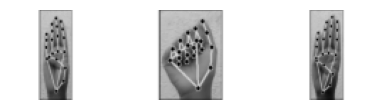

(6121, 64, 64)


In [12]:
for i in range(len(hand_signs)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(images32[hand_signs[i]], cmap="gray")
    plt.subplots_adjust(wspace=0.5)
    
plt.show()

print(images32.shape)

## Modelling using Conv2D:
We are using a pre-trained model called Conv2D under the keras library for modelling

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images32, labels, test_size = 0.3, stratify = labels)

In [14]:
#Normalization will help us remove distortions caused by lights and shadows in an image
X_train = np.array(X_train).astype('float32')/255.0
X_test = np.array(X_test).astype('float32')/255.0

In [15]:
#One hot encoding the target feature
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [16]:
model=Sequential([])

#convulation layer 1
model.add(Conv2D(64, 3, activation="relu", input_shape=(64, 64, 1)))
model.add(MaxPooling2D(2))

#convulation layer 2
model.add(Conv2D(128, 3, activation="relu"))
model.add(MaxPooling2D(2))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(91, activation="softmax"))

In [17]:
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

#fitting the model
history = model.fit(X_train, y_train, epochs = 10, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/10
67/67 [==============================] - 31s 447ms/step - loss: 3.4824 - accuracy: 0.0378 - val_loss: 3.2884 - val_accuracy: 0.0370
Epoch 2/10
67/67 [==============================] - 31s 460ms/step - loss: 3.2887 - accuracy: 0.0373 - val_loss: 3.2808 - val_accuracy: 0.0381
Epoch 3/10
67/67 [==============================] - 32s 482ms/step - loss: 3.2807 - accuracy: 0.0397 - val_loss: 3.2697 - val_accuracy: 0.0381
Epoch 4/10
67/67 [==============================] - 33s 487ms/step - loss: 3.2734 - accuracy: 0.0404 - val_loss: 3.2493 - val_accuracy: 0.0408
Epoch 5/10
67/67 [==============================] - 33s 489ms/step - loss: 2.8429 - accuracy: 0.1881 - val_loss: 2.0432 - val_accuracy: 0.4159
Epoch 6/10
67/67 [==============================] - 32s 481ms/step - loss: 1.2791 - accuracy: 0.6431 - val_loss: 0.7987 - val_accuracy: 0.7485
Epoch 7/10
67/67 [==============================] - 33s 493ms/step - loss: 0.5879 - accuracy: 0.8457 - val_loss: 0.4123 - val_accuracy: 0.9145

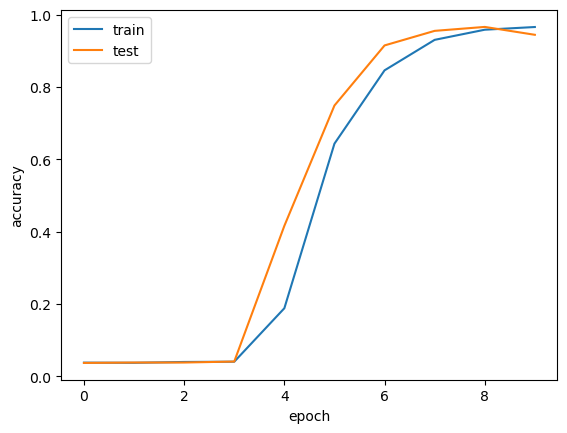

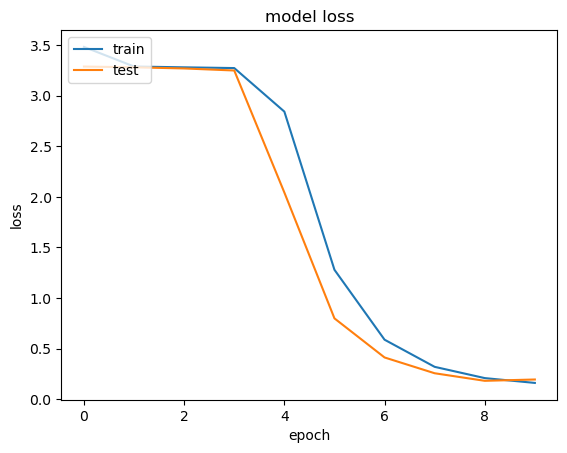

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### From the results and the figures above, it can be concluded that our model achieved quite high accuracy. The biggest advantage of our model is the lesser number of layers that are used in its creation. It makes it very easy to train and saves a lot of computational resoources